# Main - Infering a graph and analysis real data (fuel consumption in France)
*Adrien RAMANANA RAHARY, Mathilde DUPOUY*


This notebook uses the different associated scripts to infer a graph on a fuel consumption dataset.

In [80]:
from load_data import *
from solver import *
from synthetic_graphs import plot_graph, signal_smoothness_on_graph, create_graph_from_laplacian
import os,sys
sys.path.append(os.path.realpath('FGW distance on graph/lib'))
from graph import Graph
from ot_distances import Fused_Gromov_Wasserstein_distance


## Load data, test functions and create graph

In [104]:
# Load data and get information
fuel_data = Fuel_data('../__data/Donnees-annuelles-de-consommation-de-produits-petroliers-par-departement-France-metropol.2022-09.csv')
fuel_data.normalize_by_year_by_fuel()
print("number of studied fuel", fuel_data.num_fuel)
print("number of departments", fuel_data.num_dpt)
print("number of years", fuel_data.num_years)


number of studied fuel 12
number of departments 94
number of years 17


In [105]:
#Test sample one year
samples_2005, fuels = fuel_data.samples_one_year(2005)
print('Return type of Fuel_data.samples_one_year : ', type(samples_2005))
print('Shape num_dpt x num_fuels: ', samples_2005.shape)
# check normalization
print('means (close to 0) :', [np.sum(samples_2005[:, i]) / samples_2005.shape[0] for i in range(samples_2005.shape[1])])
print('std (close to 1) :', [np.sum(samples_2005[:, i] ** 2) / samples_2005.shape[0] for i in range(samples_2005.shape[1])])

Return type of Fuel_data.samples_one_year :  <class 'numpy.ndarray'>
Shape num_dpt x num_fuels:  (94, 12)
means (close to 0) : [-3.307047307394083e-17, 9.330597760147593e-17, -5.5215879150240496e-17, -4.015700301835673e-17, -8.740053598112935e-17, nan, nan, nan, nan, nan, nan, nan]
std (close to 1) : [0.9893617021276598, 0.9893617021276597, 0.9893617021276596, 0.9893617021276593, 0.9893617021276592, nan, nan, nan, nan, nan, nan, nan]


In [106]:
# Test sample by year
samples_super_plombe, years = fuel_data.samples_by_year(SUPER_SANS_PLOMB)
print('Return type of Fuel_data.samples_by_year : ', type(samples_super_plombe))
print('Shape num_dpt x num_years:', samples_super_plombe.shape)
print(years)


Return type of Fuel_data.samples_by_year :  <class 'numpy.ndarray'>
Shape num_dpt x num_years: (94, 17)
[2005, 2006, 2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


<class 'list'>


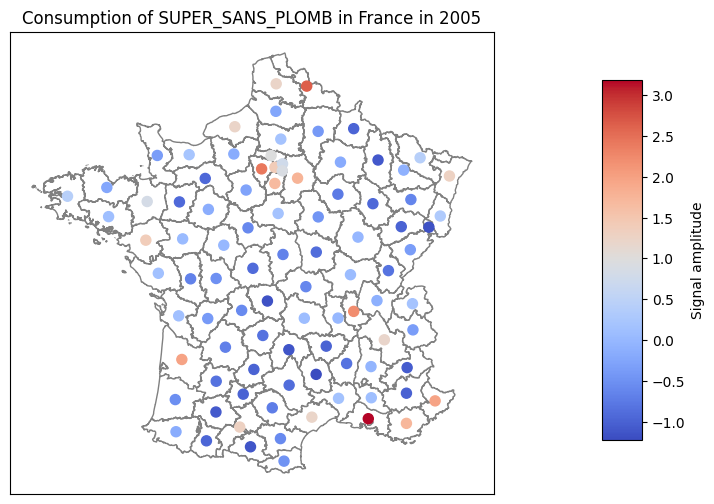

In [107]:
# Test graph construction
fuel_data.generate_graph()
print(type(fuel_data.graph.nodes[1]['pos']))
plot_graph_department(fuel_data.graph, samples_super_plombe[:, 0], title=f'Consumption of {SUPER_SANS_PLOMB} in France in {years[0]}')

## Fuel comparisons for an estimated graph across years
### Example on the Auvergne-Rhônes-Alpes region

number of fuels 12
number of departments 12
number of years 17


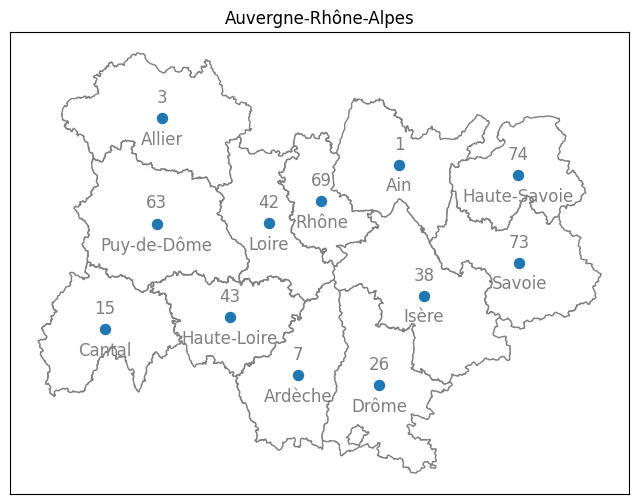

In [108]:
#Load data
region_ARA = [1, 3, 7, 15, 26, 38, 42, 43, 63, 69, 73, 74] #dpt region Auvergne Rhones Alpes
fuel_data_ARA = Fuel_data('../__data/Donnees-annuelles-de-consommation-de-produits-petroliers-par-departement-France-metropol.2022-09.csv')
fuel_data_ARA.truncate(dpt_to_keep=region_ARA)
fuel_data_ARA.normalize_by_year_by_fuel()

print("number of fuels", fuel_data_ARA.num_fuel)
print("number of departments", fuel_data_ARA.num_dpt)
print("number of years", fuel_data_ARA.num_years)
fuel_data_ARA.generate_graph()
plot_graph_department(fuel_data_ARA.graph, plot_labels=True, title="Auvergne-Rhône-Alpes")


In [109]:
# Solver
# Solver parameters
max_iter = 1000
alpha = 5e-4
beta = 4e-4
solvers.options['show_progress'] = False
np.random.seed(3)
est_graphs = {}
computed_years = {}
computed_fuels = []
for fuel in fuel_data_ARA.fuel_keys :
    sample, years = fuel_data_ARA.samples_by_year(fuel)
    # Solving only for the fuels with for minimum one year
    if len(years) >= 1 :
        computed_fuels.append(fuel)
        L_est, Y_est = gl_sig_model(sample.T, max_iter, alpha, beta)
        print(f"Fuel {fuel} for {len(years)} years")
        g_est = create_graph_from_laplacian(L_est, sorted(list(fuel_data_ARA.graph.nodes)))
        for node in g_est.nodes :
            g_est.nodes[node]['pos'] = fuel_data_ARA.graph.nodes[node]['pos']
        est_graphs[fuel] = g_est
        computed_years[fuel] = years

Fuel SUPER_PLOMBE for 3 years
Fuel SUPER_SANS_PLOMB for 17 years
Fuel GAZOLE for 17 years
Fuel FOD for 17 years
Fuel FOL for 17 years
Fuel GNR for 11 years
Fuel GPL for 7 years
Fuel SUPER_SANS_PLOMB_95 for 14 years
Fuel SUPER_SANS_PLOMB_95_E10 for 14 years
Fuel SUPER_SANS_PLOMB_98 for 14 years
Fuel SUPER_ETH_E85 for 7 years


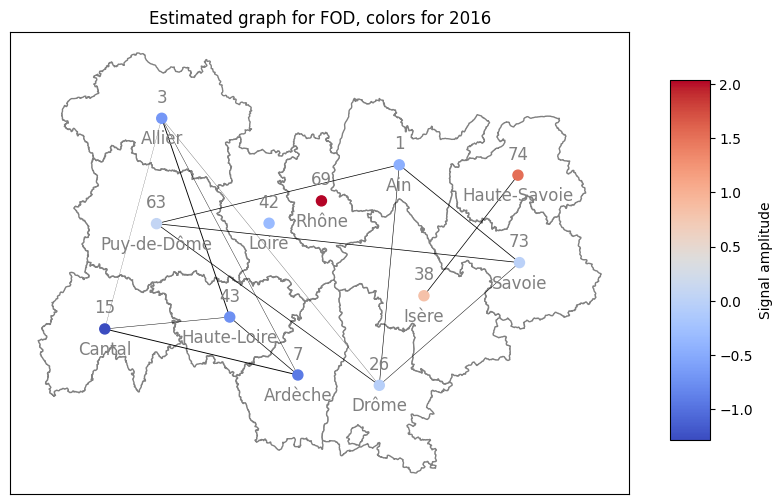

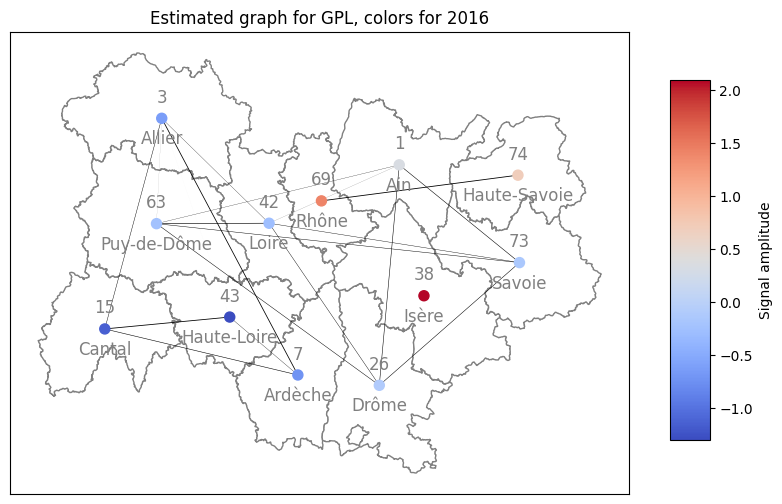

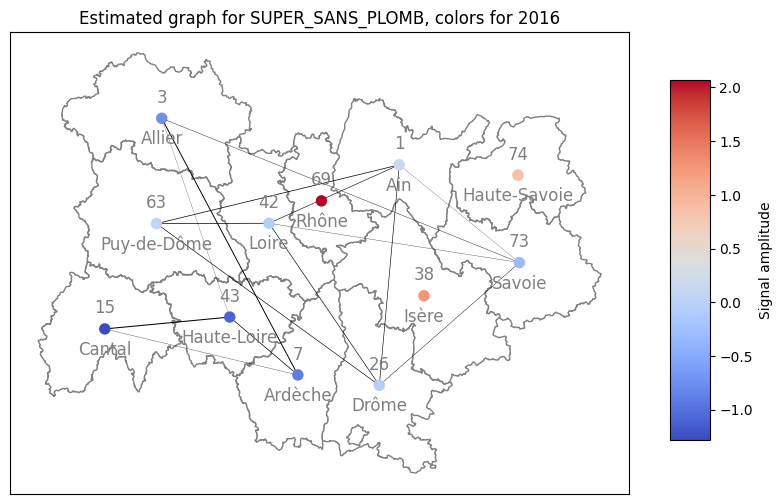

In [110]:
# Print a resulting graph
fuels = [FOD, GPL, SUPER_SANS_PLOMB]
year = 2016
for fuel in fuels :
    year_index = computed_years[fuel].index(year)
    plot_graph_department(est_graphs[fuel], node_values=fuel_data_ARA.samples_by_year(fuel)[0][:, year_index], title=f"Estimated graph for {fuel}, colors for {computed_years[fuel][year_index]}", plot_labels=True)

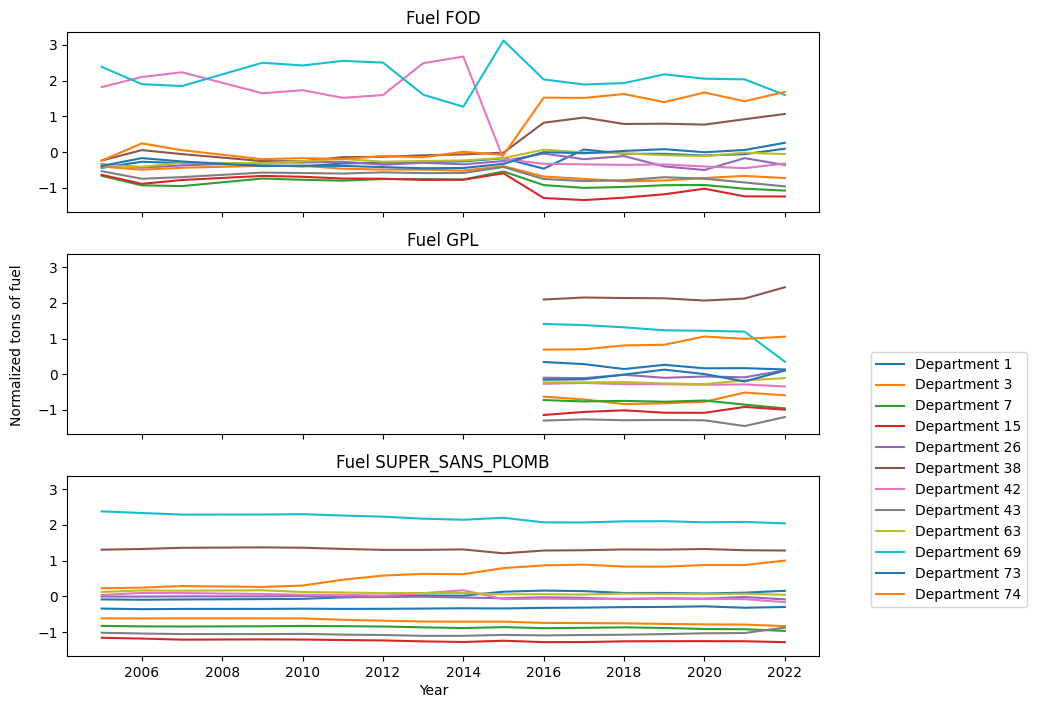

In [111]:
import matplotlib.ticker as ticker

depts = region_ARA
fuels = [FOD, GPL, SUPER_SANS_PLOMB]

fig, axs = plt.subplots(len(fuels), 1, figsize=(8, 7), sharex=True, sharey=True)
for i, fuel in enumerate(fuels) :
    for dept in depts :
        dept_index = list(est_graphs[fuel].nodes).index(dept)
        axs[i].plot(computed_years[fuel], fuel_data_ARA.samples_by_year(fuel)[0][dept_index, :], label=f'Department {dept}')
    axs[i].set_title(f'Fuel {fuel}')

# Set common x and y labels
fig.text(0.5, 0, 'Year', ha='center')
fig.text(-0.03, 0.5, 'Normalized tons of fuel', va='center', rotation='vertical')

# Common legend
handles, labels = axs[0].get_legend_handles_labels()
common_legend = fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25, 0.5))


axs[-1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='both'))
axs[-1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()


In [112]:
fuels_dist = np.zeros((len(computed_fuels), len(computed_fuels)))
for i, fuel1 in enumerate(computed_fuels) :
    g1 = est_graphs[fuel1]
    for j in range(i+1, len(computed_fuels)) :
        fuel2 = computed_fuels[j]
        g2 = est_graphs[fuel2]
        try:
            fuels_dist[i, j] = Fused_Gromov_Wasserstein_distance(alpha=1,features_metric='dirac',method='shortest_path').graph_d(Graph(g1), Graph(g2))
        except Exception as e:
            print(f"Error calculating distance for fuels {fuel1} and {fuel2}: {e}")
            fuels_dist[i, j] = np.nan
            # Uncomment the next line if you want to skip to the next iteration
            continue

fuels_dist = fuels_dist + fuels_dist.T - np.diag(np.diag(fuels_dist))

Error calculating distance for fuels SUPER_SANS_PLOMB and GNR: Alpha n a pas été trouvé
Error calculating distance for fuels FOL and GNR: Alpha n a pas été trouvé


C:\Users\mathi\AppData\Roaming\Python\Python38\site-packages\scipy\optimize\_linesearch.py:709: RuntimeWarning: divide by zero encountered in scalar divide
  alpha2 = (-b + np.sqrt(abs(b**2 - 3 * a * derphi0))) / (3.0*a)
C:\Users\mathi\OneDrive\Documents\ENS_M2_MVA\TimeSeries\learnGraph\scripts\FGW distance on graph\lib\optim.py:212: RuntimeWarning: invalid value encountered in multiply
  return np.sum(M * G) + reg * f(G)


C:\Users\mathi\AppData\Local\Temp\ipykernel_16908\3172988872.py:2: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(fuels_dist))
C:\Users\mathi\AppData\Local\Temp\ipykernel_16908\3172988872.py:3: RuntimeWarning: divide by zero encountered in log
  for (i, j), z in np.ndenumerate(np.log(fuels_dist)):


<Figure size 640x480 with 0 Axes>

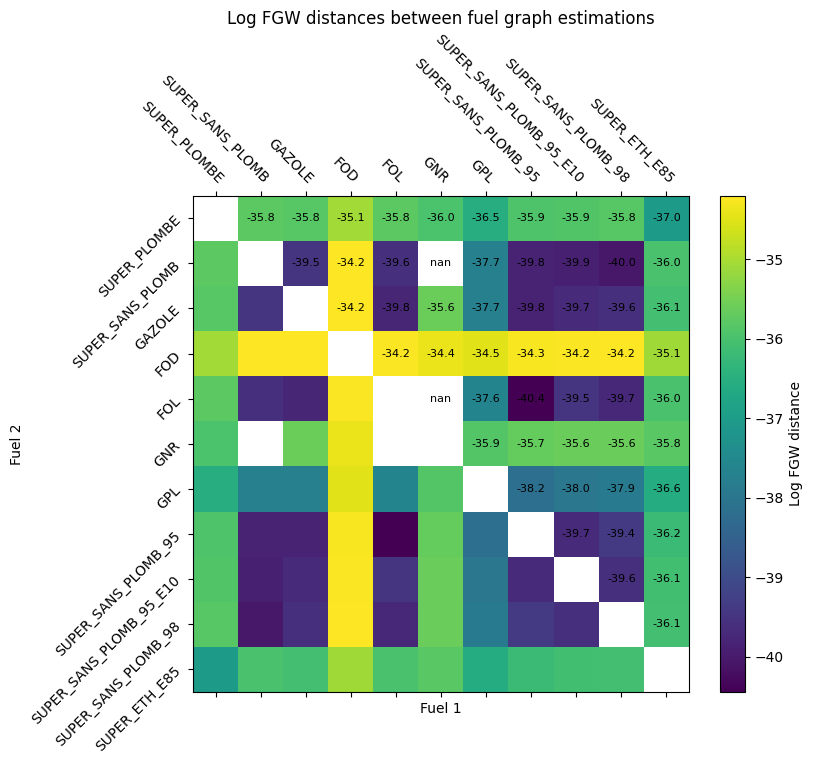

In [113]:
plt.figure()
plt.matshow(np.log(fuels_dist))
for (i, j), z in np.ndenumerate(np.log(fuels_dist)):
    if i < j :
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=8)
fig = plt.gcf()
fig.set_size_inches(8, 8)

plt.xlabel('Fuel 1')
plt.ylabel('Fuel 2')
plt.xticks(np.arange(len(computed_fuels)), computed_fuels, rotation=-45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(len(computed_fuels)), computed_fuels, rotation=45, ha='right')
plt.title("Log FGW distances between fuel graph estimations")
plt.colorbar(label='Log FGW distance', shrink=0.8)
plt.show()

In [ ]:
new_matrix = np.delete(fuels_dist, [3], axis = 0)
new_matrix = np.delete(new_matrix, [3], axis = 1)
new_computed_fuels = computed_fuels[:3] + computed_fuels[4:]
plt.figure()
plt.matshow(np.log(new_matrix))
plt.xlabel('Fuel 1')
plt.ylabel('Fuel 2')
plt.xticks(np.arange(len(new_computed_fuels)), new_computed_fuels, rotation=-45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(len(new_computed_fuels)), new_computed_fuels, rotation=45, ha='right')
plt.title("Log GW distances between fuel graph estimations")
plt.colorbar(label='Log GW distance', shrink=0.8)
plt.show()


In [29]:
fuels_dist_ged = np.zeros((len(computed_fuels), len(computed_fuels)))
for i, fuel1 in enumerate(computed_fuels) :
    g1 = est_graphs[fuel1]
    for j in range(i+1, len(computed_fuels)) :
        fuel2 = computed_fuels[j]
        g2 = est_graphs[fuel2]
        fuels_dist_ged[i, j] = nx.graph_edit_distance(g1, g2)

fuels_dist_ged = fuels_dist_ged + fuels_dist_ged.T - np.diag(np.diag(fuels_dist_ged))


KeyboardInterrupt: 

C:\Users\mathi\AppData\Local\Temp\ipykernel_16908\772073365.py:2: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(fuels_dist_ged))


<Figure size 640x480 with 0 Axes>

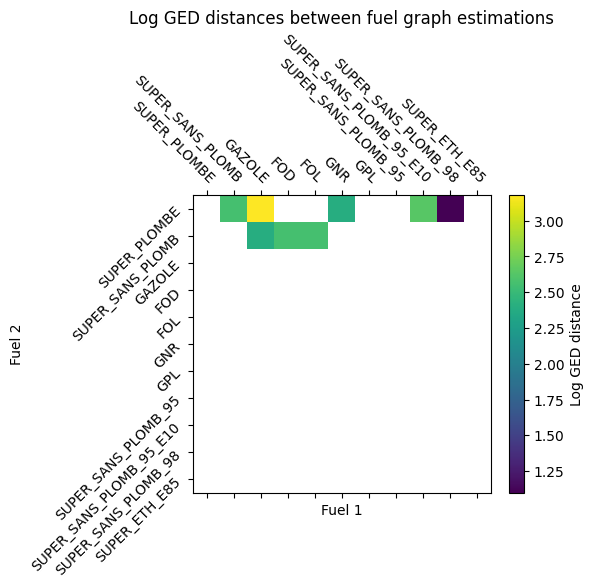

In [30]:
plt.figure()
plt.matshow(np.log(fuels_dist_ged))
plt.xlabel('Fuel 1')
plt.ylabel('Fuel 2')
plt.xticks(np.arange(len(computed_fuels)), computed_fuels, rotation=-45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(len(computed_fuels)), computed_fuels, rotation=45, ha='right')
plt.title("Log GED distances between fuel graph estimations")
plt.colorbar(label='Log GED distance', shrink=0.8)
plt.show()


#### Same experiment on whole France

In [ ]:
#Load data
fuel_data = Fuel_data('../__data/Donnees-annuelles-de-consommation-de-produits-petroliers-par-departement-France-metropol.2022-09.csv')
print("num var", fuel_data_ARA.num_fuel)
print("num dpt", fuel_data_ARA.num_dpt)
print("num years", fuel_data_ARA.num_years)
fuel_data.generate_graph()
plot_graph_department(fuel_data.graph)


In [ ]:
# Solver
# Solver parameters
max_iter = 1000
alpha = 5e-4
beta = 4e-4
solvers.options['show_progress'] = False
np.random.seed(3)
est_graphs = {}
computed_years = {}
computed_fuels = []
for fuel in fuel_data_ARA.fuel_keys :
    sample, years = fuel_data.samples_by_year(fuel)
    # Solving only for the fuels with for minimum one year
    if len(years) >= 1 :
        computed_fuels.append(fuel)
        L_est, Y_est = gl_sig_model(sample.T, max_iter, alpha, beta)
        print(f"Fuel {fuel} for {len(years)} years, L_est shape : {L_est.shape}")
        g_est = create_graph_from_laplacian(L_est, sorted(list(fuel_data.graph.nodes)))
        for node in g_est.nodes :
            g_est.nodes[node]['pos'] = fuel_data.graph.nodes[node]['pos']
        est_graphs[fuel] = g_est
        computed_years[fuel] = years

In [ ]:
# Print a resulting graph
fuel = SUPER_SANS_PLOMB
plot_graph_department(est_graphs[fuel], node_values=fuel_data.samples_by_year(fuel)[0][:, 0])

In [ ]:
fuels_dist = np.zeros((len(computed_fuels), len(computed_fuels)))
for i, fuel1 in enumerate(computed_fuels) :
    g1 = est_graphs[fuel1]
    for j in range(i+1, len(computed_fuels)) :
        fuel2 = computed_fuels[j]
        g2 = est_graphs[fuel2]
        fuels_dist[i, j] = Fused_Gromov_Wasserstein_distance(alpha=1,features_metric='dirac',method='shortest_path').graph_d(Graph(g1), Graph(g2))



### Same experiment for another region

number of fuels 12
number of department 12
number of years 17


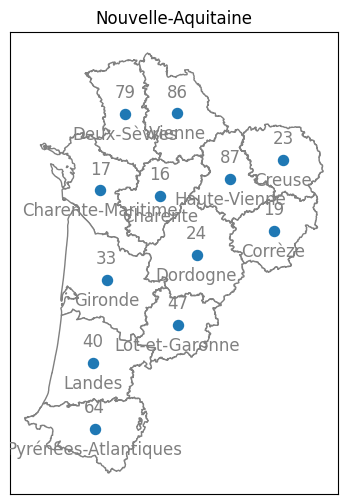

In [98]:
#Load data
available_regions = ['Grand Est', 'Nouvelle-Aquitaine', 'Occitanie', 'Normandie', 'Bourgogne-Franche-Comté', 'Centre-Val de Loire', 'Pays de la Loire', 'Auvergne-Rhône-Alpes',\
                     'Hauts-de-France', "Provence-Alpes-Côte d'Azur", 'Bretagne', 'Île-de-France']
i_region = 1
fuel_data_region = Fuel_data('../__data/Donnees-annuelles-de-consommation-de-produits-petroliers-par-departement-France-metropol.2022-09.csv')
region_dpts = list(set(fuel_data_region.dataframe_fuel[fuel_data_region.dataframe_fuel[REGION_LIBELLE] == available_regions[i_region]][DEPARTEMENT_CODE]))
fuel_data_region.truncate(dpt_to_keep=region_dpts)
fuel_data_region.normalize_by_year_by_fuel()
print("number of fuels", fuel_data_region.num_fuel)
print("number of department", fuel_data_region.num_dpt)
print("number of years", fuel_data_region.num_years)
fuel_data_region.generate_graph()
plot_graph_department(fuel_data_region.graph, plot_labels=True, title=available_regions[i_region])


In [99]:
# Solver
# Solver parameters
max_iter = 1000
alpha = 5e-4
beta = 4e-4
solvers.options['show_progress'] = False
np.random.seed(3)
est_graphs = {}
computed_years = {}
computed_fuels = []
for fuel in fuel_data_region.fuel_keys :
    sample, years = fuel_data_region.samples_by_year(fuel)
    # Solving only for the fuels with for minimum one year
    if len(years) >= 1 :
        computed_fuels.append(fuel)
        L_est, Y_est = gl_sig_model(sample.T, max_iter, alpha, beta)
        print(f"Fuel {fuel:25} for {len(years)} years")
        g_est = create_graph_from_laplacian(L_est, sorted(list(fuel_data_region.graph.nodes)))
        for node in g_est.nodes :
            g_est.nodes[node]['pos'] = fuel_data_region.graph.nodes[node]['pos']
        est_graphs[fuel] = g_est
        computed_years[fuel] = years

Fuel SUPER_PLOMBE              for 3 years
Fuel SUPER_SANS_PLOMB          for 17 years
Fuel GAZOLE                    for 17 years
Fuel FOD                       for 17 years
Fuel FOL                       for 17 years
Fuel GNR                       for 11 years
Fuel GPL                       for 7 years
Fuel SUPER_SANS_PLOMB_95       for 14 years
Fuel SUPER_SANS_PLOMB_95_E10   for 14 years
Fuel SUPER_SANS_PLOMB_98       for 14 years
Fuel SUPER_ETH_E85             for 7 years


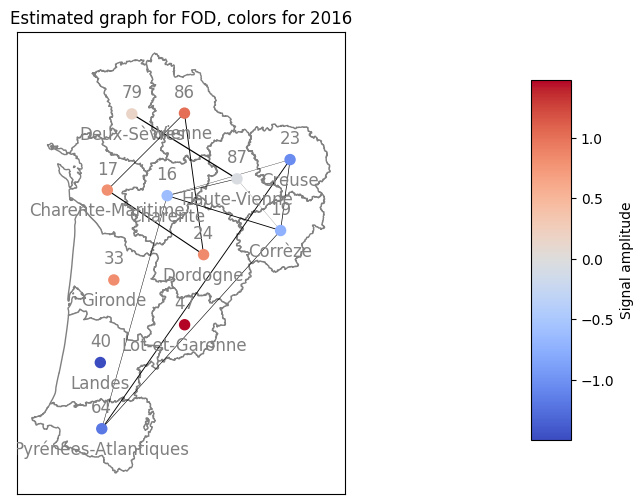

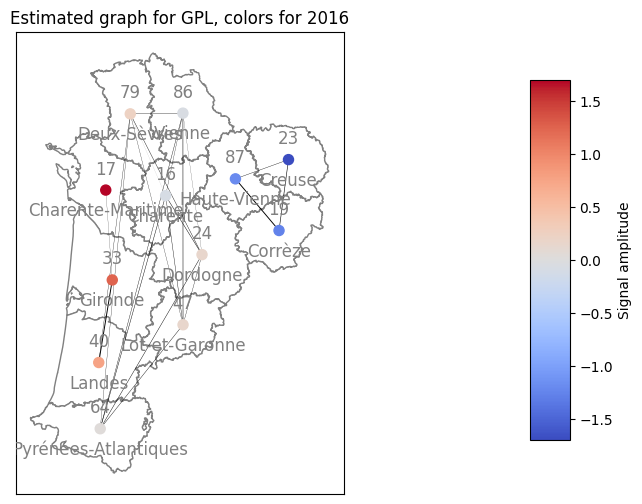

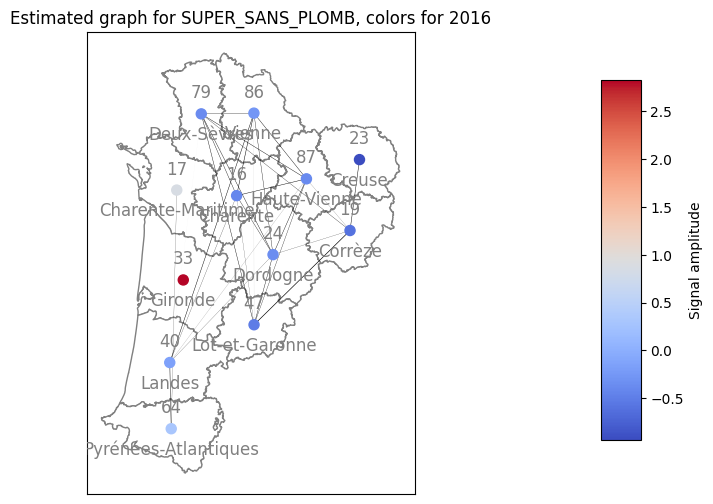

In [100]:
# Print a resulting graph
fuels = [FOD, GPL, SUPER_SANS_PLOMB]
year = 2016
for fuel in fuels :
    year_index = computed_years[fuel].index(year)
    plot_graph_department(est_graphs[fuel], node_values=fuel_data_region.samples_by_year(fuel)[0][:, year_index], title=f"Estimated graph for {fuel}, colors for {computed_years[fuel][year_index]}", plot_labels=True)

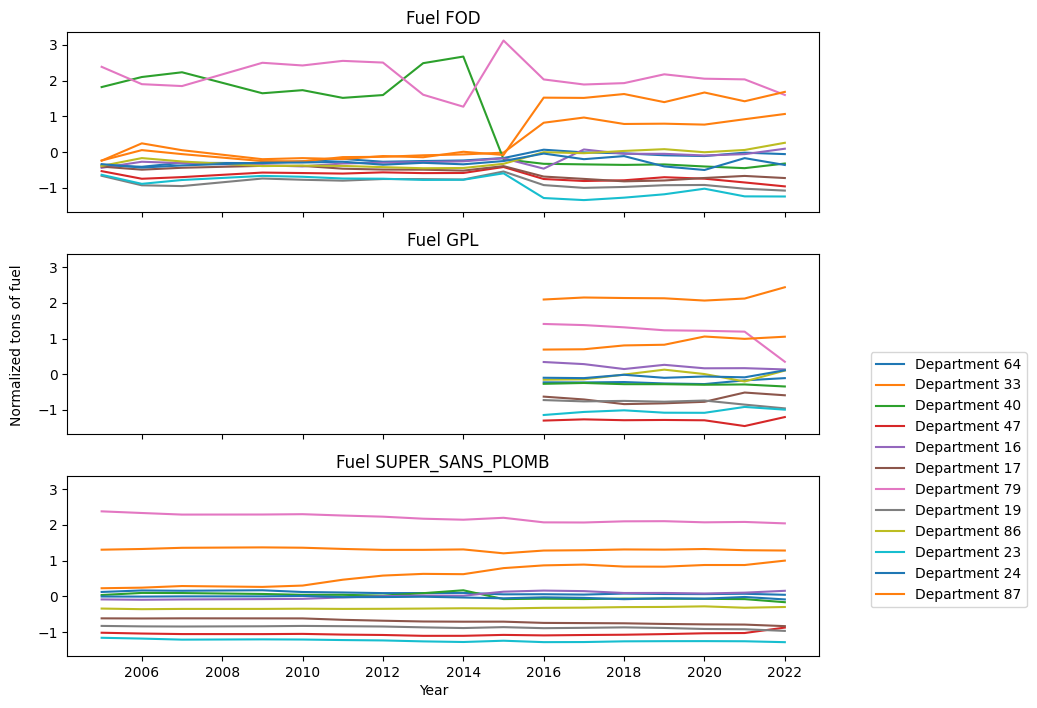

In [101]:
import matplotlib.ticker as ticker

depts = region_dpts
fuels = [FOD, GPL, SUPER_SANS_PLOMB]

fig, axs = plt.subplots(len(fuels), 1, figsize=(8, 7), sharex=True, sharey=True)
for i, fuel in enumerate(fuels) :
    for dept in depts :
        dept_index = list(est_graphs[fuel].nodes).index(dept)
        axs[i].plot(computed_years[fuel], fuel_data_ARA.samples_by_year(fuel)[0][dept_index, :], label=f'Department {dept}')
    axs[i].set_title(f'Fuel {fuel}')

# Set common x and y labels
fig.text(0.5, 0, 'Year', ha='center')
fig.text(-0.03, 0.5, 'Normalized tons of fuel', va='center', rotation='vertical')

# Common legend
handles, labels = axs[0].get_legend_handles_labels()
common_legend = fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(1.25, 0.5))


axs[-1].xaxis.set_major_locator(ticker.MaxNLocator(integer=True, prune='both'))
axs[-1].xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

# Adjust layout to prevent clipping of titles
plt.tight_layout()
plt.show()


In [102]:
fuels_dist = np.zeros((len(computed_fuels), len(computed_fuels)))
for i, fuel1 in enumerate(computed_fuels) :
    g1 = est_graphs[fuel1]
    for j in range(i+1, len(computed_fuels)) :
        fuel2 = computed_fuels[j]
        g2 = est_graphs[fuel2]
        try:
            fuels_dist[i, j] = Fused_Gromov_Wasserstein_distance(alpha=1, features_metric='dirac', method='shortest_path').graph_d(Graph(g1), Graph(g2))
        except Exception as e:
            print(f"Error calculating distance for fuels {fuel1} and {fuel2}: {e}")
            fuels_dist[i, j] = np.nan
            # Uncomment the next line if you want to skip to the next iteration
            continue
fuels_dist = fuels_dist + fuels_dist.T - np.diag(np.diag(fuels_dist))


C:\Users\mathi\AppData\Local\Temp\ipykernel_16908\624744034.py:2: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(fuels_dist))
C:\Users\mathi\AppData\Local\Temp\ipykernel_16908\624744034.py:3: RuntimeWarning: divide by zero encountered in log
  for (i, j), z in np.ndenumerate(np.log(fuels_dist)):


<Figure size 640x480 with 0 Axes>

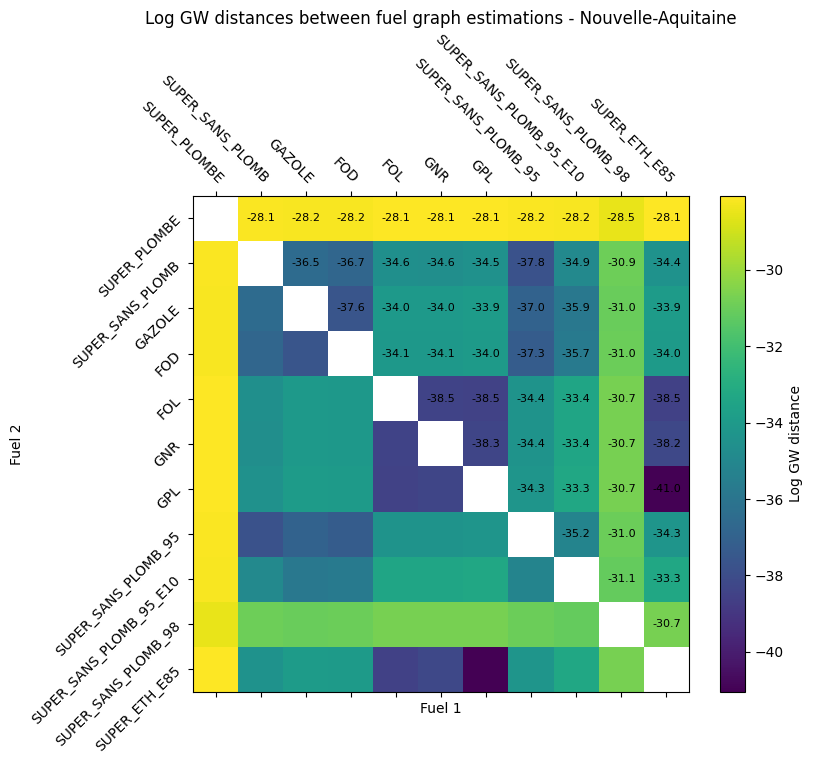

In [103]:

plt.figure()
plt.matshow(np.log(fuels_dist))
for (i, j), z in np.ndenumerate(np.log(fuels_dist)):
    if i < j :
        plt.text(j, i, '{:0.1f}'.format(z), ha='center', va='center', fontsize=8)
fig = plt.gcf()
fig.set_size_inches(8, 8)

plt.xlabel('Fuel 1')
plt.ylabel('Fuel 2')
plt.xticks(np.arange(len(computed_fuels)), computed_fuels, rotation=-45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(len(computed_fuels)), computed_fuels, rotation=45, ha='right')
plt.title(f"Log GW distances between fuel graph estimations - {available_regions[i_region]}")
plt.colorbar(label='Log GW distance', shrink=0.8)
plt.show()